# Import stuff

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import enchant
from sklearn.feature_extraction.text import CountVectorizer

# Dataset Preparation

In [2]:
true = pd.read_csv('../raw_data/True.csv')
fake = pd.read_csv('../raw_data/Fake.csv')

In [3]:
true.drop(columns = ['subject','date'], inplace = True)
fake.drop(columns = ['subject','date'], inplace = True)

In [4]:
true['score'] = 1
fake['score'] = 0

In [5]:
data = pd.concat([true,fake],ignore_index=True)

# Cleaning

In [6]:
data.head()

,title,text,score
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


In [7]:
import string

punc = string.punctuation + '“' + '”' + '’' + '‘'
def remove_punctuation(text):
    for punctuation in punc:
        text = text.replace(punctuation, '')
    return text

def remove_numbers(text):
    text = ''.join(word for word in text if not word.isdigit())
    return text



In [102]:
# Remove numbers
data['title_clean']=data['title'].apply(remove_numbers)

data['text_clean']=data['text'].apply(remove_numbers)

In [103]:
# Remove punctuation to title

data['title_clean']=data['title'].apply(remove_punctuation)

In [104]:
# Remove punctuation to text

data['text_clean']=data['text'].apply(remove_punctuation)

In [105]:
# Stop words removal

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

data['title_clean'] = data['title_clean'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop_words)]))
data['text_clean'] = data['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop_words)]))

In [106]:
#Tokenize Text

def tokenize_text(text):
    return text.split()
data['title_tokens']=data['title_clean'].apply(tokenize_text)
data['text_tokens']=data['text_clean'].apply(tokenize_text)

In [107]:
# Define a function to find wrong words and return the count

english = enchant.DictWithPWL("en_US", "vocab.txt")
wrong_words={}
correct_words=set()
def get_typos_t(tokens):
     wrong_count=0
     for token in tokens:
            if token in wrong_words:
                wrong_words[token]+=1
                wrong_count+=1
            else:
                if not token in correct_words:    
                    if not english.check(token) and not english.check(token.capitalize()):
                        wrong_words[token]=1
                        wrong_count+=1
                    else:
                        correct_words.add(token)
     return wrong_count       

In [108]:
# Defining a function to get tokens in text
def get_tokens_text(df):
    get_tokens = set()
    for text in df['text']:
        split_text = text.split()
        for token in split_text:
            get_tokens.add(token)
    return get_tokens

tokens_fake = get_tokens_text(fake)
tokens_true = get_tokens_text(true)

In [109]:
print(len(tokens_fake),len(tokens_true))

293553 178503


# Create new features

In [110]:
data['title_token_count']=data['title_tokens'].apply(lambda tokens:len(tokens))
data['text_token_count']=data['text_tokens'].apply(lambda tokens:len(tokens))

In [111]:
data['wrong_title_token_count']=data['title_tokens'].apply(get_typos_t)
data['wrong_text_token_count']=data['text_tokens'].apply(get_typos_t)

In [112]:
data['title_typo_ratio']= data['wrong_title_token_count']/data['title_token_count']
data['text_typo_ratio']= data['wrong_text_token_count']/data['text_token_count']


# Plotting

<AxesSubplot:xlabel='score', ylabel='title_typo_ratio'>

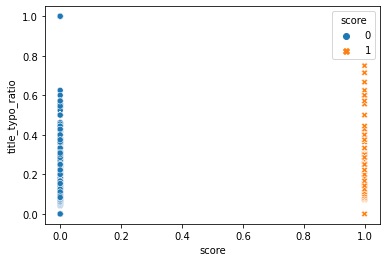

In [17]:
sns.scatterplot(data=data, x="score", y="title_typo_ratio", hue="score", style="score")

<AxesSubplot:xlabel='score', ylabel='text_typo_ratio'>

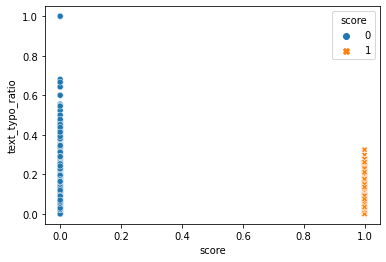

In [18]:
sns.scatterplot(data=data, x="score", y="text_typo_ratio", hue="score", style="score")

In [19]:
data_clean = data[['title', 'text', 'title_clean', 'text_clean','title_tokens',
       'text_tokens','text_typo_ratio', 'score']].copy()

# Clean logistic Regression

In [113]:
y=data['score']

In [114]:
# feature_cols = ['title', 'text', 'title_clean', 'text_clean','title_tokens',
#        'text_tokens','text_typo_ratio']
feature_cols = ['title_clean', 'text_clean','text_typo_ratio']

x=data_clean[feature_cols]

In [115]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0,test_size=0.3)

In [118]:
x_train.head()

,title_clean,text_clean,text_typo_ratio
33958,BREAKING FINALLY New Wikileaks Email…We going ...,latest Wikileaks email evidence smoke Hillary ...,0.099730
19813,German liberals would expect finance ministry ...,BERLIN Reuters Germany Free Democrats FDP woul...,0.137143
25814,Trump LOSES Complete Nervous Breakdown Worst W...,Trump bad week First humiliated front millions...,0.053659
18689,Merkel Macron pledge lead EU forward postBrexit,TALLINN Reuters French President Emmanuel Macr...,0.058957
44673,AMERICAN TRAGEDY Really Killed JonBenét Ramsey,roses know thorns hurt quote attributed JonBen...,0.105163


In [119]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
preprocessor = ColumnTransformer([
    ('vectorizer_title', CountVectorizer(), 'title_clean'),
    ('vectorizer_text', CountVectorizer(), 'text_clean'),

    #insert function here
    
    
])
final_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('Logistic', LogisticRegression())])

In [120]:
final_pipe.fit(x_train,y_train)

/Users/andreamontagnoli/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Pipeline(memory=None,
     steps=[('preprocessing', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('vectorizer_title', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [121]:
final_pipe.score(x_test,y_test)

0.997253155159614

In [122]:
y_test.shape

(13470,)

In [123]:
test= '''President Donald Trump is trying to steal a free and fair election that he lost by a wide margin to President-elect Joe Biden by tearing at the most basic principle of American democracy: He's trying to throw out hundreds of thousands of votes.
Trump's latest escalation of his attempt to subvert the result of the election followed a string of knock-backs in the courts and after a statewide audit in Georgia confirmed Biden's victory in the crucial swing state.
He asked state Republican leaders in Michigan to visit him Friday, hinting at a possible attempt to convince them to ignore Biden's big win in the state and send a slate of electors to the Electoral College that backs him and not the President-elect. Both Michigan House Speaker Lee Chatfield and Senate Majority Leader Mike Shirkey will meet with Trump at the White House at 4 p.m. ET, according to a source familiar with the plans.
This follows the President's calls to two Wayne County GOP officials, who are now seeking to take back their votes to certify Biden's victory.
Trump's lawyer, Rudy Giuliani, who rampaged through an unhinged news conference Thursday, is in effect baselessly arguing that troves of Democratic mail-in ballots, many of them cast by Black voters, are illegal and that Trump has therefore won the election with room to spare.
"It changes the result of the election in Michigan if you take out Wayne County," Giuliani said at a crowded, mask-free and delusional news conference featuring Trump's crew of TV lawyers in Washington.
Giuliani's team is also making absurd claims of a massive, centralized, Democratic conspiracy involving long-dead Venezuelan dictator Hugo Chavez, Cuba, China, the Clinton Foundation and George Soros to throw the election.'''

In [124]:
title="Trump undercuts American democracy as he clings to power"
test_series=pd.Series(test)
title_series=pd.Series(title)

In [125]:
test

'President Donald Trump is trying to steal a free and fair election that he lost by a wide margin to President-elect Joe Biden by tearing at the most basic principle of American democracy: He\'s trying to throw out hundreds of thousands of votes.\nTrump\'s latest escalation of his attempt to subvert the result of the election followed a string of knock-backs in the courts and after a statewide audit in Georgia confirmed Biden\'s victory in the crucial swing state.\nHe asked state Republican leaders in Michigan to visit him Friday, hinting at a possible attempt to convince them to ignore Biden\'s big win in the state and send a slate of electors to the Electoral College that backs him and not the President-elect. Both Michigan House Speaker Lee Chatfield and Senate Majority Leader Mike Shirkey will meet with Trump at the White House at 4 p.m. ET, according to a source familiar with the plans.\nThis follows the President\'s calls to two Wayne County GOP officials, who are now seeking to 

In [135]:
test_df=pd.DataFrame({'title_clean':title_series,'text_clean':test_series, 'text_typo_ratio':[0.1]})

In [136]:
test_df

,title_clean,text_clean,text_typo_ratio
0,Trump undercuts American democracy as he cling...,President Donald Trump is trying to steal a fr...,0.1


In [137]:
# preprocessor = ColumnTransformer([
#     ('vectorizer_title', CountVectorizer(), 'title_clean'),
#     ('vectorizer_text', CountVectorizer(), 'text_clean'),

# ])
# final_pipe = Pipeline([
#     ('preprocessing', preprocessor),
#     ('Logistic', LogisticRegression())])

In [138]:
final_pipe.predict(test_df)

array([0])

In [33]:
# score=accuracy_score(y_test,pred)
# score

# Dirty logistic regression

In [40]:
y=data['score']

# feature_cols = ['title', 'text', 'title_clean', 'text_clean','title_tokens',
#        'text_tokens','text_typo_ratio']
feature_cols = ['title', 'text','text_typo_ratio']

x_dirty=data_clean[feature_cols]

In [41]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(x_dirty,y,random_state=0,test_size=0.3)

In [42]:
preprocessor = ColumnTransformer([
    ('vectorizer_title', CountVectorizer(), 'title'),
    ('vectorizer_text', CountVectorizer(), 'text'),

])
final_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('Logistic', LogisticRegression())])

In [43]:
final_pipe.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('preprocessing', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('vectorizer_title', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [44]:
final_pipe.score(X_test,y_test)

0.9974016332590943